In [1]:
%run radiomorpho.py

In [2]:
dirs  = ('101first_fit', '101nvss_fit')
files = get_file_list(dirs[1], 'fit')
# images = [readNormalizedImg(im) for im in files]
images = []
for im in files:
    try:
        img = readNormalizedImg(im)
        images.append(img)
    except:
        pass

In [3]:
def img_distance(im1, im2):
    dif = im1 - im2
    return np.linalg.norm(dif)

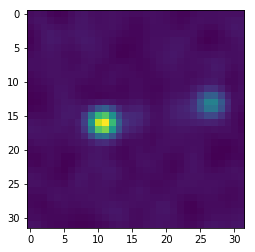

In [4]:
plt.imshow(images[0])
plt.show()

In [5]:
from skimage.transform import rotate, rescale

In [6]:
def best_rotate(im1, im2):
    min_dist = img_distance(im1, im2)
    angle = 0
    for i in range(1, 360):
        im_r = rotate(im2, i)
        ndist = img_distance(im1, im_r)
        if(ndist < min_dist):
            min_dist = ndist
            angle = i
    return angle

def best_rotate_flip(im1, im2):
    angle = best_rotate(im1, im2)
    im2_r = rotate(im2, angle)
    min_dist = img_distance(im1, im2_r)
    angle_f = best_rotate(im1, im2[:,::-1])
    im2_rf = rotate(im2[:,::-1], angle)
    min_dist_f = img_distance(im1, im2_rf)
    if(min_dist_f < min_dist): return (angle_f, True)
    return (angle, False)

In [7]:
def min_size(images):
    min_sz = images[0].shape[0]
    for i in range(1, len(images)):
        if min_sz > images[i].shape[0]: min_size = images[i].shape[0]
    return min_sz

def reshape_images(images, sz):
    return [rescale(im, (sz/im.shape[0], sz/im.shape[1])) for im in images]

In [8]:
def min_size(images):
    min_sz = images[0].shape[0]
    for i in range(1, len(images)):
        if min_sz > images[i].shape[0]: min_size = images[i].shape[0]
    return min_sz

In [9]:
sz = min_size(images)
images_r = reshape_images(images, sz)

/Users/jperalta/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/jperalta/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jperalta/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
best_rotate_flip(images_r[0], images_r[1])

(310, False)

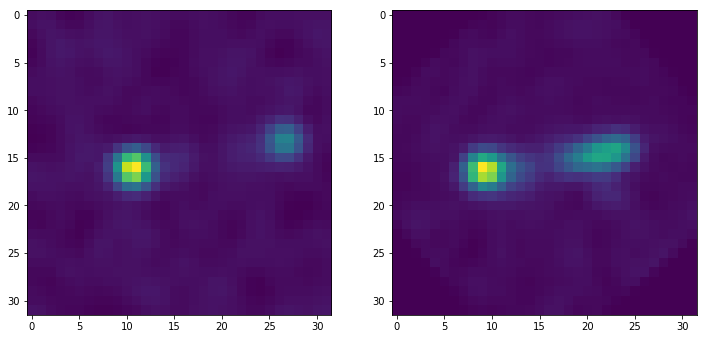

In [11]:
f, ax = plt.subplots(1, 2, figsize=(12,15))
ax[0].imshow(images_r[0])
ax[1].imshow(rotate(images_r[1],310))

In [14]:
%time
def procrates_dist(images_r, n_iter = 5):
    avg_img = images_r[0]
    new_avg = np.zeros_like(avg_img)
    for it in range(n_iter):
        for i in range(len(images_r)):
            angle, flip = best_rotate_flip(avg_img, images_r[i])
            images_r[i] = rotate(images_r[i], angle)
            if(flip): images_r[i] = images_r[i][:,::-1]
            new_avg += images_r[i] / len(images_r)
        avg_img = new_avg
    return images_r, avg_img

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [15]:
%time
images_r, avg_img = procrates_dist(images_r)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs


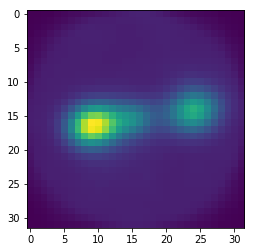

In [16]:
plt.imshow(avg_img)

In [17]:
dt = [img.reshape(1, 32*32) [0] for img in images_r]
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(dt)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
Y = pca.transform(dt)
xs, ys = Y[:,0] , Y[:,1]
plt.scatter(xs, ys)

<IPython.core.display.Javascript object>


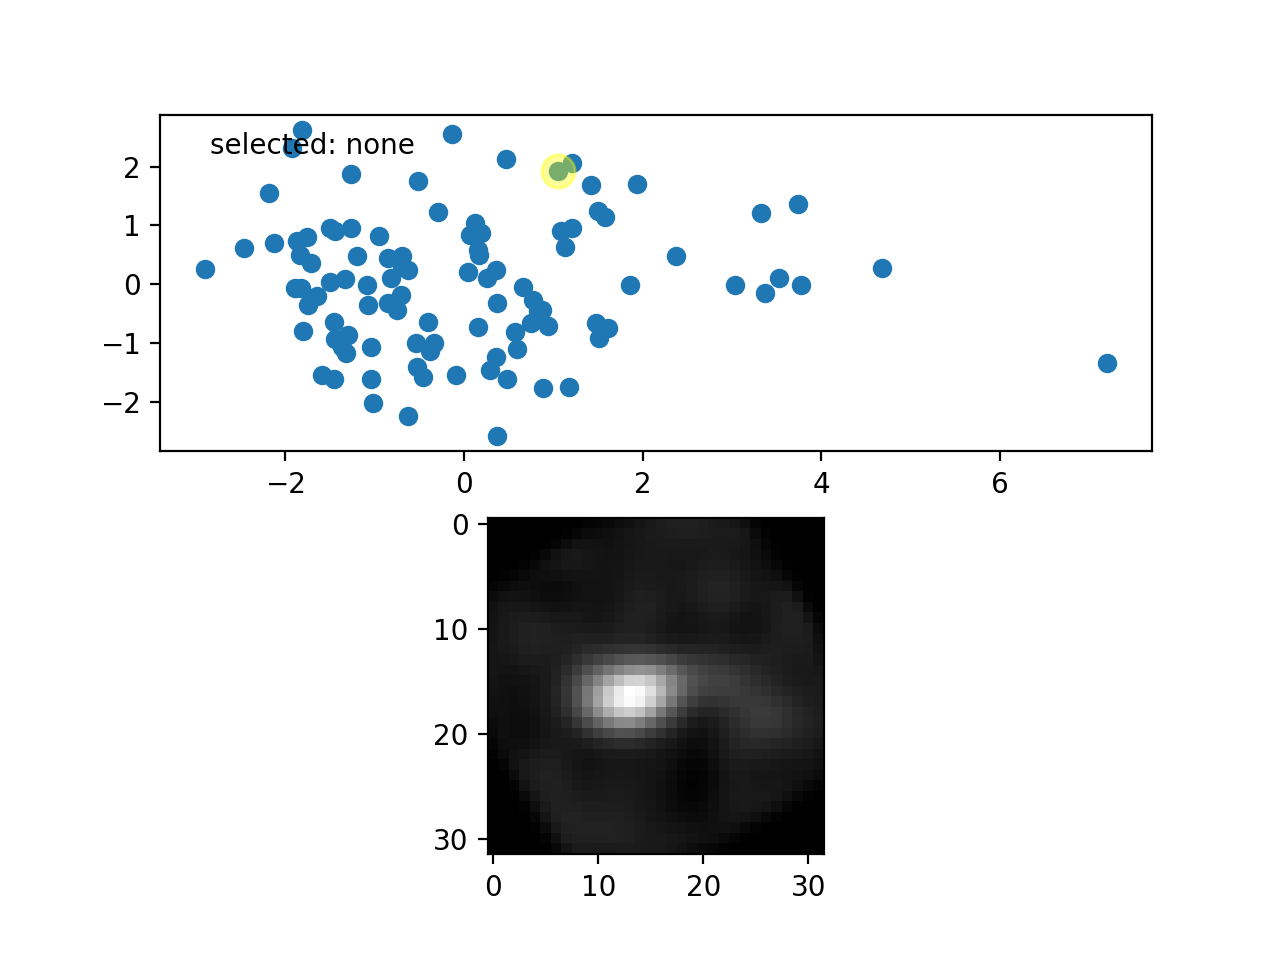

In [30]:
%matplotlib notebook
class DataBrowser(object):
    """
    Click on a point to select and highlight it -- the data that
    generated the point will be shown in the lower axes.  Use the 'n'
    and 'p' keys to browse through the next and previous points
    """

    def __init__(self, fig, ax1, ax2, xs, ys):
        self.lastind = 0

        self.text = ax1.text(0.05, 0.95, 'selected: none',
                            transform=ax1.transAxes, va='top')
        self.selected, = ax1.plot([xs[0]], [ys[0]], 'o', ms=12, alpha=0.4,
                                 color='yellow', visible=False)
        self.xs = xs
        self.ys = ys
        self.fit = fig

        self.ax2 = ax2

    def onpress(self, event):
        if self.lastind is None:
            return
        if event.key not in ('n', 'p'):
            return
        if event.key == 'n':
            inc = 1
        else:
            inc = -1

        self.lastind += inc
        self.lastind = np.clip(self.lastind, 0, len(self.xs) - 1)
        self.update()

    def onpick(self, event):

        if event.artist != line:
            return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        x = event.mouseevent.xdata
        y = event.mouseevent.ydata

        distances = np.hypot(x - self.xs[event.ind], y - self.ys[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind

        img = images_r[dataind]
        self.ax2.cla()
        self.ax2.imshow(img, cmap='gray')

        self.selected.set_visible(True)
        self.selected.set_data(self.xs[dataind], self.ys[dataind])

#         self.text.set_text('selected: {}'.format(
#             '.'.join(files[dataind].split('/')[1].split('.')[:-2])))
        self.fig.canvas.draw()

fig, (ax, ax2) = plt.subplots(2, 1)
line, = ax.plot(xs, ys, 'o', picker=5)
browser = DataBrowser(fig, ax, ax2, xs, ys)
fig.canvas.mpl_connect('pick_event', browser.onpick)
fig.canvas.mpl_connect('key_press_event', browser.onpress)
plt.show()

In [24]:
from sklearn.manifold import TSNE

In [25]:
dt = np.array(dt)

In [26]:
dt_e = TSNE(n_components=2).fit_transform(dt)

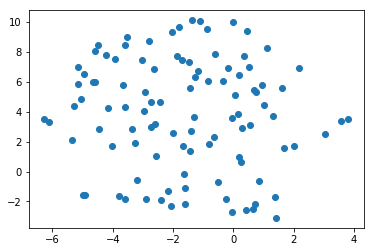

In [27]:
xs, ys = dt_e[:,0], dt_e[:,1]
plt.scatter(xs, ys)